# Цель исследования

Мы работаем в интернет-магазине, который продаёт по всему миру компьютерные игры. Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Будем следовать плану, указанному ниже:
- [ознакомимся с данными](#1)
- [займемся их предобработкой](#2)
- [проведем иссследовательсктй анализ показателей и зависимостей](#3)
- [изучим портрет типичного геймера](#4)
- [проведем статистический анализ стоящих перед нами гипотез](#5)
- [подытожим нашу работу](#6)

<a id='1'></a>
## Знакомство с файлом

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st

In [2]:
df = pd.read_csv('C:\\Users\\Александр\Datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<a id='2'></a>

## Предобработка данных

Для дальнейшего анализа нам будет удобнее работать с названиями столбцов в нижнем регистре. Это мы и сделаем.

In [4]:
df.columns = [x.lower () for x in df.columns]

### Приведение типов

Приведем к нужному типу столбцы с датами

In [5]:
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y')
df['year_of_release'] = df['year_of_release'].dt.year

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Обработка пропусков

Мы видим, что в некоторых столбцах есть пропуски, и перед нами стоит задача - что с ними делать: оставлять, удалять или заполнять конкретными значениями. Думается, что наибольшее влияние на дальнейший анализ окажут  пропуски в столбце года - поэтому удалим их. Удаленные значения составят около 1%, что нас вполне устроит. Остальные пропуски трогать не будем. 

In [7]:
df.dropna(subset = ['year_of_release'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


От коллег мы знаем, что в столбце user_score есть непонятная на первый взгляд аббревиатура 'tbd'. Но оказывается: она лишь означает, что пользовательская оценка только "будет объявлена". Поэтому вполне логичным будет заменить аббревиатуру на None.

In [9]:
display(df[df['user_score'] == 'tbd'].head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E


In [10]:
df['user_score'] = df['user_score'].apply(lambda x: None if x == 'tbd' else x)

### Добавление данных

Далее нам для расчетов также пригодится столбец с суммарными продажами каждой игры по всем регионам.

In [11]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [12]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Теперь данные готовы для дальнейшего анализа

<a id='3'></a>
## Исследовательский анализ

### Выбор актуального периода

Прежде чем начинать подробный анализ данных, нам стоит понять, какой период все-таки брать во внимание. Посмотрим сначала на выпуск игр по годам

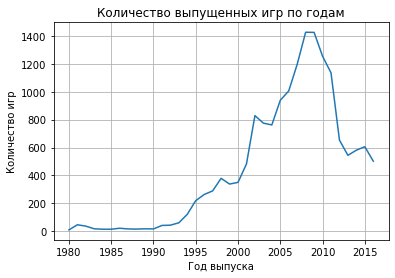

In [13]:
#сколько игры выпускалось в разные годы
df_year_name = df.groupby('year_of_release')['name'].count().reset_index()
plt.plot(df_year_name['year_of_release'], df_year_name['name'])
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.title('Количество выпущенных игр по годам')
plt.grid(True)

Видим длинный хвост значений слева, и это вполне объяснимо. Игры стали популярными с развитием ПК и консолей. И их развитие началось в середине 90х, а с 2000 года продолжился бурный рост. А спад последних лет, скорее всего, связан с развитием мобильных игр. Далее нам предстоит разобраться с деньгами: сколько денег зарабатывали производители игр по годам и какой период все-таки брать для анализа.

### Динамика продаж по платформам

Определим топ-10 по продажам

In [14]:
top10_platform = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).reset_index()

Cоздадим список из топ-10 платформ, чтобы в дальнейшем к нему обращаться


In [15]:
top10_platform = top10_platform['platform'].tolist()

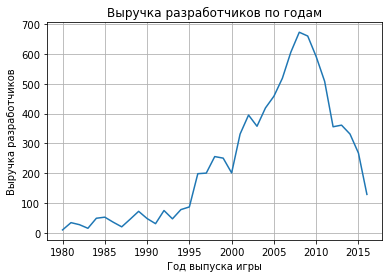

In [16]:
#сколько денег получили разработчики игр в разные годы
df_top10 = df.groupby('year_of_release')['total_sales'].sum().reset_index()
plt.plot(df_top10['year_of_release'], df_top10['total_sales'])
plt.xlabel('Год выпуска игры')
plt.ylabel('Выручка разработчиков')
plt.title('Выручка разработчиков по годам')
plt.grid(True)

По графику видим, что имеется пик продаж в 2008. Но какой же период брать для анализа? Думаем, что можно рассчитать средний срок жизни платформы и отсчитать его назад от 2015-го года. Для этого возьмем все платформы и посмотрим, в течение какого времени у них совершались продажи

In [17]:
diff_df = df.groupby('platform').agg({'year_of_release': ['min', 'max']})
diff_df['diff'] = diff_df['year_of_release', 'max'] - diff_df['year_of_release', 'min']
#упростим восприятие таблицы, убрав мультииндексы
diff_df.columns = ['year_min', 'year_max', 'diff']
#display(diff_df.sort_values(by='year_max', ascending=False).head(10))
diff_df.describe()

,year_min,year_max,diff
count,31.000000,31.000000,31.000000
mean,1997.645161,2005.258065,7.612903
std,9.094131,9.273503,6.998464
min,1980.000000,1989.000000,0.000000
25%,1992.500000,1996.000000,3.000000
50%,1996.000000,2007.000000,6.000000
75%,2004.500000,2016.000000,10.000000
max,2013.000000,2016.000000,31.000000


In [18]:
diff_df.query('year_max < 2016').describe()

,year_min,year_max,diff
count,22.000000,22.000000,22.000000
mean,1993.863636,2000.863636,7.000000
std,6.088987,7.291844,6.256425
min,1980.000000,1989.000000,0.000000
25%,1990.500000,1995.000000,2.250000
50%,1994.000000,2000.000000,6.500000
75%,1998.750000,2007.000000,9.750000
max,2004.000000,2015.000000,28.000000


Поскольку у нас имеются экстремальные значения, и медиана не равна среднему, примем за средний период жизни платформы срок в 6 лет. И напоминаем, что актуальными данными для последующих расчетов считаем период с 2010 по 2015 включительно. Нам нужно понять, какие платформы из топ-10 лидируют по продажам (растут или падают) и выбрать несколько потенциально прибыльных платформ.

Отфильтруем данные по параметрам, которые указали выше

In [19]:
df_good = df.query('2009 < year_of_release < 2016') 
df_good.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010.0,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
27,Pokemon Black/Pokemon White,DS,2010.0,Role-Playing,5.51,3.17,5.65,0.80,NaN,NaN,NaN,15.13
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73


Актуальный период выделен. Так в рассмотрение попадут только последние поколения платформ, а также будем рассматривать только конечный на данный момент интервал развития игровой индустрии. 

Построим график, отражающий тенеденции в продажах по платформам в годовом разрезе


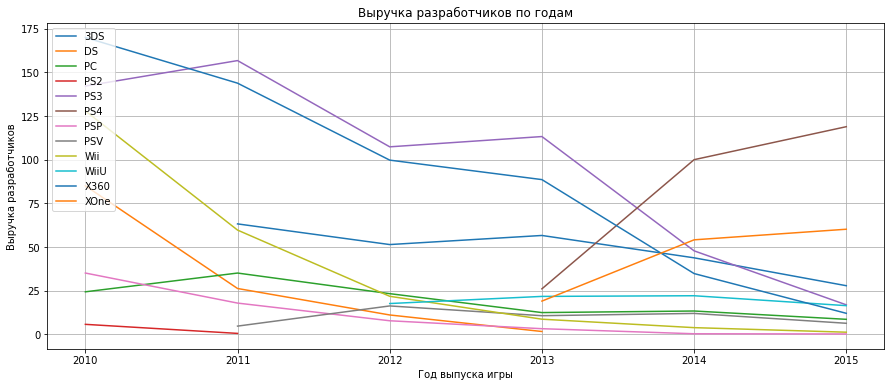

In [20]:
fig, ax = plt.subplots(figsize = (15,6))
df_good.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(ax=ax)
plt.xlabel('Год выпуска игры')
plt.ylabel('Выручка разработчиков')
plt.title('Выручка разработчиков по годам')
plt.grid(True)
ax.legend(loc='upper left')
plt.show()

Найдем самые прибыльные платформы

In [21]:
df_good.groupby('platform')['total_sales'].sum().reset_index().sort_values('total_sales', ascending=False).head(10)

,platform,total_sales
4,PS3,584.14
10,X360,548.89
5,PS4,244.89
0,3DS,242.67
8,Wii,222.79
11,XOne,133.17
1,DS,123.75
2,PC,116.71
9,WiiU,77.59
6,PSP,64.05


Из графика видим, что самыми прибыльными платформами за период являются PS2, X360 и PS3. Также стоит отметить, что игровая индустрия переживает трудные времена: суммарная выручка по продажам падает из года в год. И если компания планирует выпускать новые игры на своей платформе - нужно тщательно просчитывать все показатели, которые влияют на конечную выручку. Пока только можем констатировать, что есть две платформы, которые демонстрируют рост продаж - PS4 и XOne. Они и является потенциально прибыльными на 2017 год

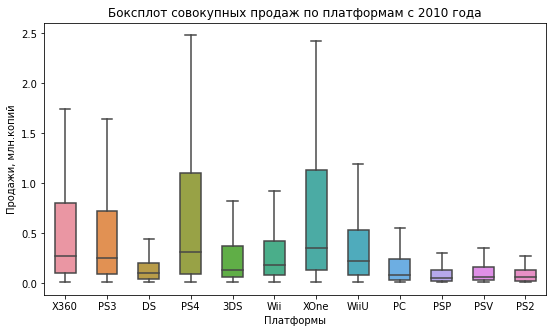

In [22]:
plt.figure(figsize=(9,5))
sns.boxplot(x='platform', y='total_sales', data=df_good, showfliers=False, width=0.5)
plt.title('Боксплот совокупных продаж по платформам с 2010 года')
plt.xlabel('Платформы')
plt.ylabel('Продажи, млн.копий')
plt.show()

Из диаграмм размаха видим, что на всех платформах наблюдается одинаковая картина: среднее сильно выше медианы. Это говорит о том, что на всех платформах есть несколько игр, которые "делают кассу". А остальные игры не приносят сильно ощутимого дохода.

Думается, что разница между платформами связана со сменой поколений приставок. PS4 и XOne относятся к восьмому поколению, и объективно могут стоить дороже платформ предыдущего поколения - X360 и PS3. Также свое влияние оказывает и число платформ на рынке. Чем их больше, тем большее число игр продается на них.

        *Примечание. 3DS, Wii и WiiU тоже восьмого, но менее распространены, так как являются портативными.

### Зависимость продаж от оценок критиков и пользователей

Обычно на конечные продажи сильно влияют оценочные факторы со стороны пользователей и критиков. Выпускается пилотный проект - он тестируется - и по результатам теста принимается решение, масштабировать продукт или нет. И если на начальной стадии экспертные и геймерские оценки совпадают - игру ждет успех. Проверим эту гипотезу на примере нескольких платформ: 7 поколения  и 8 (отдельно стационарные и портативные)

#### Стационарные платформы 8 поколения

Помним, что корреляцию нужно считать по сырым данным, и сделаем выборку по стационарным платформам 8 поколения. Итоговый вывод сформируем после того, как построим все графики по трем группа

In [23]:
df_gen8_stat = df.query('platform == "PS4" or platform == "XOne"')
display(df_gen8_stat.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,Call of Duty: Advanced Warfare,PS4,2014.0,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66


In [24]:
df_gen8_stat['user_score'] = df_gen8_stat['user_score'].astype(float)

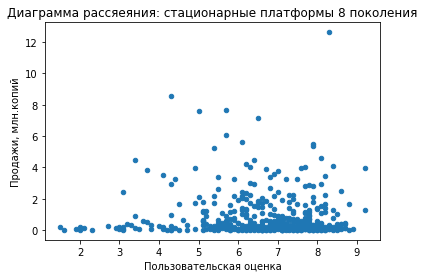

In [25]:
df_gen8_stat.plot(x='user_score', y='total_sales', kind='scatter')
plt.title('Диаграмма рассяеяния: стационарные платформы 8 поколения')
plt.xlabel('Пользовательская оценка')
plt.ylabel('Продажи, млн.копий')
plt.show()

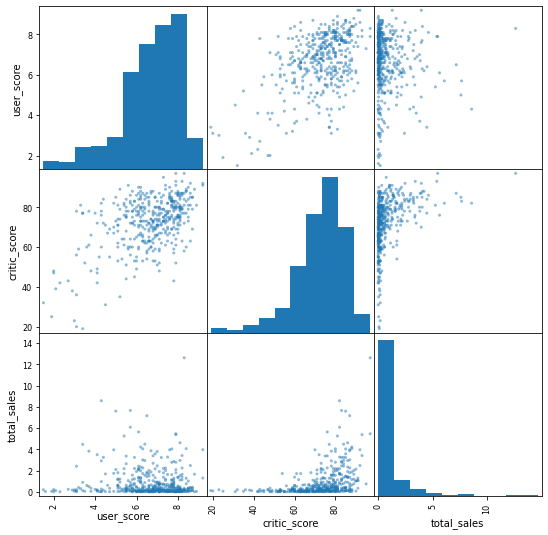

In [26]:
pd.plotting.scatter_matrix(df_gen8_stat[['user_score', 'critic_score', 'total_sales']], figsize=(9, 9)) 
plt.show()

In [27]:
display(df_gen8_stat['critic_score'].corr(df_gen8_stat['total_sales']))
display(df_gen8_stat['user_score'].corr(df_gen8_stat['total_sales']))


0.39457483802473464

-0.03596822547789379

#### Портативные платформы 8 поколения

Создадим выборку по платформам 8 поколения, приведем к нужному типу столбец с данными, построим диаграмму рассеяния



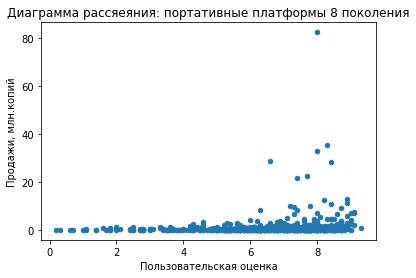

In [28]:
df_gen8_port = df.query('platform == "3DS" or platform == "Wii" or platform == "WiiU"')

df_gen8_port['user_score'] = df_gen8_port['user_score'].astype(float)

df_gen8_port.plot(x='user_score', y='total_sales', kind='scatter')
plt.title('Диаграмма рассяеяния: портативные платформы 8 поколения')
plt.xlabel('Пользовательская оценка')
plt.ylabel('Продажи, млн.копий')
plt.show()

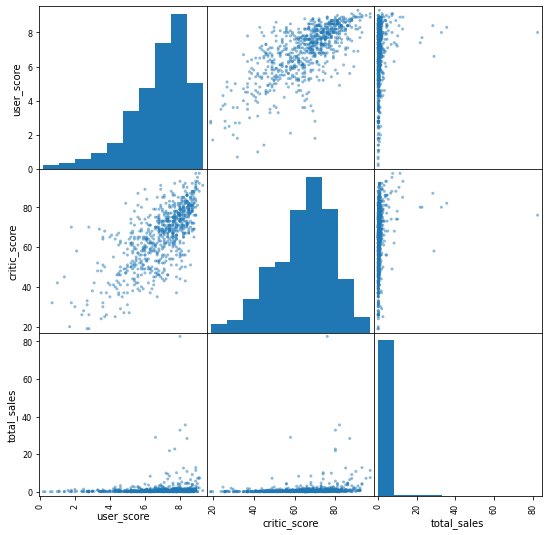

In [29]:
pd.plotting.scatter_matrix(df_gen8_port[['user_score', 'critic_score', 'total_sales']], figsize=(9, 9)) 
plt.show()

In [30]:
print(df_gen8_port['critic_score'].corr(df_gen8_port['total_sales']))
print(df_gen8_port['user_score'].corr(df_gen8_port['total_sales']))

0.1736318961700458
0.12188313973578711


#### Стационарные платформы 7 поколения

Создадим выборку по платформам 7 поколения, приведем к нужному типу столбец с данными, построим диаграмму рассеяния

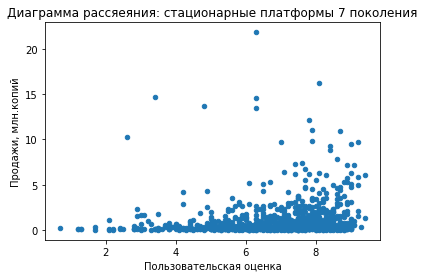

In [31]:
df_gen7_stat = df.query('platform == "X360" or platform == "PS"')

df_gen7_stat['user_score'] = df_gen7_stat['user_score'].astype(float)

df_gen7_stat.plot(x='user_score', y='total_sales', kind='scatter') 
plt.title('Диаграмма рассяеяния: стационарные платформы 7 поколения')
plt.xlabel('Пользовательская оценка')
plt.ylabel('Продажи, млн.копий')
plt.show()

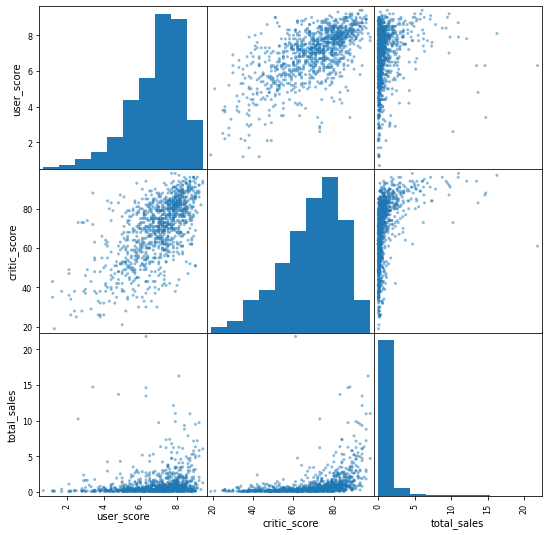

In [32]:
pd.plotting.scatter_matrix(df_gen7_stat[['user_score', 'critic_score', 'total_sales']], figsize=(9, 9)) 
plt.show()

In [33]:
display(df_gen7_stat['critic_score'].corr(df_gen7_stat['total_sales']))
display(df_gen7_stat['user_score'].corr(df_gen7_stat['total_sales']))

0.4053679856283578

0.15736272527034875

Это довольно интересно. Из графиков корреляции видим, что пользовательская оценка практически ника не коррелирует с продажами игр на платформах (показатели от 0 до 0,15). Оценка критиков - чуть больше, но все равно корреляция слабая (от 0,17 на портативных до 0,4 на стационарных). Так что четкой взаимосвязи между оценками и продажами мы не видим

### Распределение игр по жанрам. Прибыльность жанров

Изучим распределение игр по жанрам: какие из них наиболее распространены, а какие имеют самую большую долю в общей сумме продаж

In [34]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


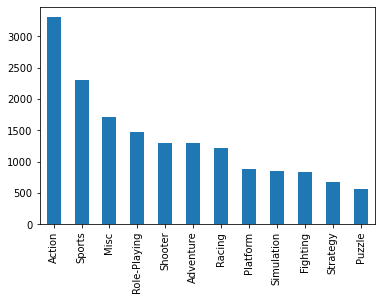

In [35]:
df['genre'].value_counts().plot(kind='bar', fontsize=10)
plt.show()

Из графика видим, что самыми распространенными у геймеров являются экшн, спортивные и "всякая всячина". Менее всего популярны головоломки, стратегии и бои. 

Теперь посмотрим, какие жанры самые кассовые

In [36]:
report = df.groupby('genre').agg({'total_sales': 'sum'})
report['%'] = report['total_sales'] / report['total_sales'].sum() * 100
display(report.sort_values(by='%', ascending=False))

,total_sales,%
genre,,
Action,1716.52,19.474109
Sports,1309.67,14.858351
Shooter,1041.36,11.814344
Role-Playing,931.08,10.563205
Platform,825.55,9.365956
Misc,790.29,8.965927
Racing,723.49,8.208074
Fighting,442.66,5.022027
Simulation,387.96,4.401449


Самыми кассовыми являются экшн, спорт и шутеры.

Из двух группировок видим, что призовые тройки не совпадают полностью. Это говорит о том, что шутер, пусть и не самый распространенный среди производителей, тем не менее приносит ощутимую выручку. То есть вкладываться в его производство довольно выгодно. Если говорить о замыкающей тройке, то стоит отметить что самым невыгодным жанром является adventure: по выручке он предпоследний, хотя по распространенности находится в середине списка.

<a id='4'></a>

## Портрет пользователя

Теперь исследуем портрет пользователя: какие платформы и жанры самые популярные в регионах, как влияет рейтинг ESRB на продажи

### Популярные в регионах платформы

In [37]:
eu_plat = df_good.groupby('platform').agg({'eu_sales': 'sum'}).head(10)
eu_plat['%'] = eu_plat['eu_sales'] / eu_plat['eu_sales'].sum() * 100

na_plat = df_good.groupby('platform').agg({'na_sales': 'sum'}).head(10)
na_plat['%'] = na_plat['na_sales'] / na_plat['na_sales'].sum() * 100

jp_plat = df_good.groupby('platform').agg({'jp_sales': 'sum'}).head(10)
jp_plat['%'] = jp_plat['jp_sales'] / jp_plat['jp_sales'].sum() * 100

na_plat.merge(eu_plat, on='platform', how='outer').merge(jp_plat, on='platform', how='outer')

,na_sales,%_x,eu_sales,%_y,jp_sales,%
platform,,,,,,
3DS,78.51,11.663250,58.94,10.069533,92.59,33.063134
DS,59.66,8.862941,28.06,4.793877,27.90,9.962862
PC,37.71,5.602104,65.29,11.154392,0.00,0.000000
PS2,2.32,0.344653,1.67,0.285309,0.80,0.285673
PS3,228.58,33.957275,212.34,36.276972,57.96,20.697043
PS4,87.25,12.961642,109.31,18.674936,10.22,3.649479
PSP,9.65,1.433580,7.59,1.296704,42.20,15.069276
PSV,12.32,1.830228,12.68,2.166299,18.28,6.527639
Wii,121.14,17.996256,65.80,11.241522,17.75,6.338380


Глобальных различий в доле продаж платформ по регионам мы не видим: ТОП-5 забирает весь рынок. Различия есть только в порядке убывания доли. Из более-менее заметных нюансов можем отметить бОльшую популярность 3DS в Японии. Скорее всего, это связано с тем, что мобильность жителей Японии более высока по сравнению с другими регионами, и портативная система 3DS больше подходит под такой ритм жизни.

### Популярные в регионах жанры

In [38]:
eu_genre = df_good.groupby('genre').agg({'eu_sales': 'sum'}).sort_values(by='eu_sales', ascending=False).head(10)
eu_genre['%'] = eu_genre['eu_sales'] / eu_genre['eu_sales'].sum() * 100

na_genre = df_good.groupby('genre').agg({'na_sales': 'sum'}).sort_values(by='na_sales', ascending=False).head(10)
na_genre['%'] = na_genre['na_sales'] / na_genre['na_sales'].sum() * 100

jp_genre = df_good.groupby('genre').agg({'jp_sales': 'sum'}).sort_values(by='jp_sales', ascending=False).head(10)
jp_genre['%'] = jp_genre['jp_sales'] / jp_genre['jp_sales'].sum() * 100

na_genre.merge(eu_genre, on='genre', how='outer').merge(jp_genre, on='genre', how='outer')

,na_sales,%_x,eu_sales,%_y,jp_sales,%
genre,,,,,,
Action,281.35,26.458335,222.95,28.897501,65.13,23.609802
Shooter,221.23,20.804612,155.55,20.161499,12.98,4.705285
Sports,149.27,14.037447,104.83,13.587464,14.59,5.288915
Misc,123.04,11.570761,65.43,8.480662,23.25,8.428188
Role-Playing,106.16,9.983355,71.20,9.228536,96.93,35.137389
Platform,53.61,5.041519,36.91,4.784063,15.70,5.691293
Racing,45.38,4.267564,52.98,6.866964,6.67,2.417893
Fighting,37.21,3.499252,18.99,2.461375,13.15,4.766911
Simulation,26.23,2.466686,25.12,3.255910,12.97,4.701660


### Влияние рейтинга ESRB на продажи

Теперь изучим, как влияет рейтинг на продажи в регионах

Предварительно проверим, какие значения у нас принимаюь ячейки в столбце рейтинга

In [39]:
df_good['rating'].unique()

array(['E', 'M', nan, 'E10+', 'T', 'EC', 'RP'], dtype=object)

Видим, что есть пропущенные значения в столбце, заменим их на wr (without raiting)

In [40]:
df_good.loc[df_good['rating'].isna(), 'rating'] = 'wr'

In [41]:
eu_r = df_good.groupby('rating').agg({'eu_sales': 'sum'})
eu_r['%'] = eu_r['eu_sales'] / eu_r['eu_sales'].sum() * 100

na_r = df_good.groupby('rating').agg({'na_sales': 'sum'})
na_r['%'] = na_r['na_sales'] / na_r['na_sales'].sum() * 100

jp_r = df_good.groupby('rating').agg({'jp_sales': 'sum'})
jp_r['%'] = jp_r['jp_sales'] / jp_r['jp_sales'].sum() * 100

na_r.merge(eu_r, on='rating', how='outer').merge(jp_r, on='rating', how='outer')

,na_sales,%_x,eu_sales,%_y,jp_sales,%
rating,,,,,,
E,263.18,24.245495,183.73,23.257256,46.80,16.373369
E10+,155.57,14.331908,95.47,12.084963,12.77,4.467691
EC,1.13,0.104101,0.00,0.000000,0.00,0.000000
M,366.55,33.768471,275.50,34.873859,29.25,10.233355
RP,0.00,0.000000,0.03,0.003798,0.00,0.000000
T,151.86,13.990124,103.29,13.074849,39.84,13.938355
wr,147.19,13.559900,131.97,16.705275,157.17,54.987230


Как видим, в Северной Америке и Европе наиболее популярны игры с рейтингом М и Е: это игры с категорией "от 17" и "для всех". В Японии же рейтинг не присвоен более, чем половине игр. Это может быть связано с тем, что ESRB все-таки американский рейтинг. И возможно, игры в Японии без рейтинга - это именно те игры, которые не продавались на запад

### Региональные потреты пользователей

Теперь подытожим данные по портретам и разложим их по регионам. Но для начала напишем функцию, которая будет принимать на вход интересующий нас регион и связь продаж с нужным параметром (жанр, платформа, рейтинг).

In [42]:
def portrait(xxx):
    fig = plt.figure()
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Проданные копии, млн.')
    ax = fig.add_subplot(111)
    ax.bar(height=xxx.iloc(axis=1)[0], x=xxx.index, label='sum')
    ax2 = ax.twinx()
    ax2.plot(xxx.iloc(axis=1)[1], 'or', label='percent')
    ax.grid()
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left')
    plt.show()

#### Европа

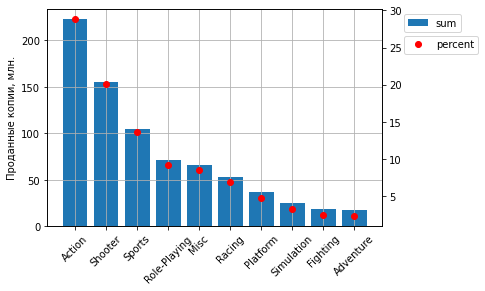

In [43]:
portrait(eu_genre)

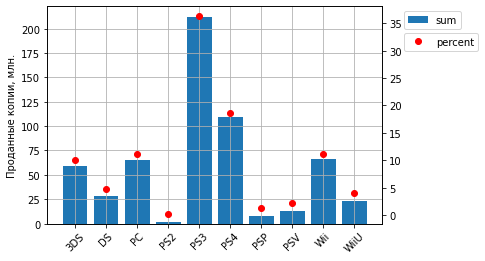

In [44]:
portrait(eu_plat)

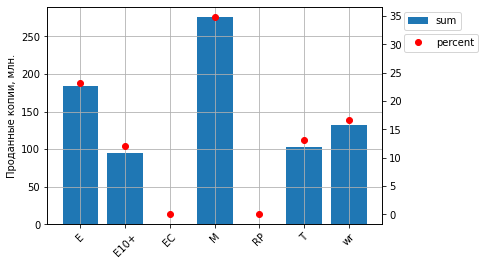

In [45]:
portrait(eu_r)

Европейский геймер включает в себя две аудитории (как подросток от 17, так и всех возрастов), играющие в экшн или шутер на PS3 / PS4  

#### Северная Америка

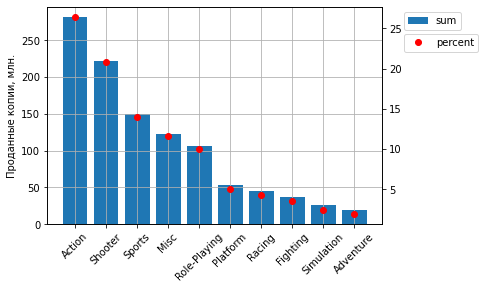

In [46]:
portrait(na_genre)

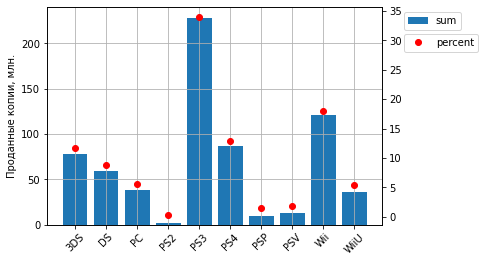

In [47]:
portrait(na_plat)

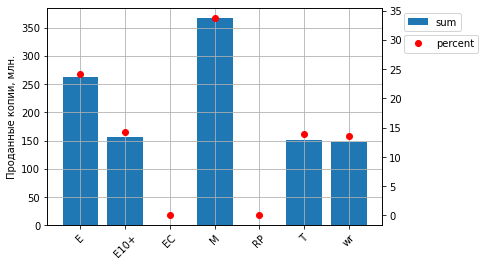

In [48]:
portrait(na_r)

Американский геймер похож на европейского: включает в себя две аудитории (как подросток от 17, так и всех возрастов), которые играют в экшн или шутер на PS3 или Wii 

#### Япония

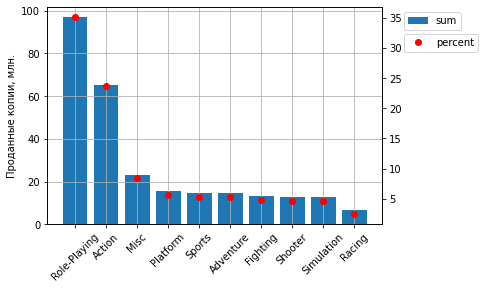

In [49]:
portrait(jp_genre)

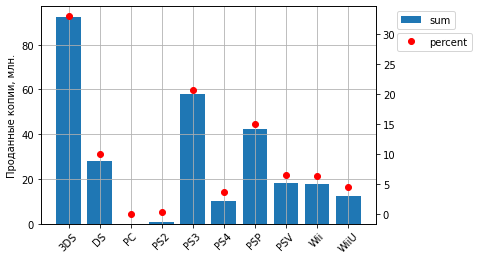

In [50]:
portrait(jp_plat)

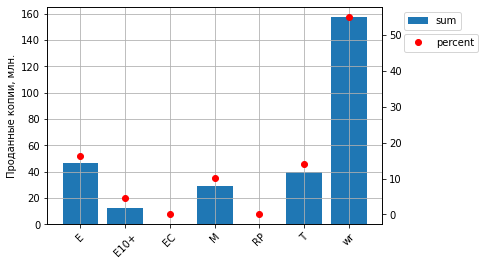

In [51]:
portrait(jp_r)

Японский геймер разительно отличается от геймера в других регионах: он играет в РПГ и экшн, на платформах 3DS и PS3. Япония своеобразная страна во всех отношениях, и это распределение тому подтверждение. Причем  более чем у половины игр рейтинг не определен.

<a id='5'></a>

## Проверка гипотез

### Рейтинги платформ

Поскольку мы будем сравнивать пользоватеьлскую оценку по двум платформам, нам стоит сразу сгруппировать эти выборки. Сгруппируем данные, выдвинем гипотезу и проверим ее

In [52]:
XOne = df.query('platform == "XOne"')['user_score']
PC = df.query('platform == "PC"')['user_score']

#PC.fillna(0, inplace=True)
XOne = XOne.astype(float)
PC = PC.astype(float)


    H0: Показатели рейтинга пользователей платформ "Xone" и "PC" равны друг другу
    H1: Показатели рейтинга пользователей платформ не равны друг другу

Для того, чтобы проверить гипотезы, сначала нам нужно сравнить дисперсии двух совокупностей (чтобы определиться с параметром equal_var)

In [53]:
np.var(XOne)

1.8965188383045533

In [54]:
np.var(PC)

2.3461128196131775

In [55]:
alpha = 0.05 #если p-value окажется меньше него - отвергнем гипотезу

# Т.к. дисперсии выборок имеют различие больше 5%, то используем параметр equal_var = False
# и поскольку у нас имеются пропуски в столбцах, проигнорируем их с помощью опции omit
results = st.ttest_ind(XOne, PC, equal_var = False, nan_policy = 'omit')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.538580296377245e-06
Отвергаем нулевую гипотезу


Вывод: мы отвергаем гипотезу о том, что показатели рейтинга пользователей платформ "Xone" и "PC" равны друг другу

### Рейтинги жанров

Теперь нам нужно сравнить средние пользовательские рейтинги жанров Action  и Sports

    H0: Показатели рейтинга пользователей жанров Action  и Sports одинаковые
    H1: Показатели рейтинга пользователей жанров Action  и Sports разные

In [56]:
Action = df.query('genre == "Action"')['user_score']
Sports = df.query('genre == "Sports"')['user_score']

Action = Action.astype(float)
Sports = Sports.astype(float)

In [57]:
np.var(Action)

2.026364874182167

In [58]:
np.var(Sports)

2.6206293039045394

In [59]:
alpha = 0.05 #если p-value окажется меньше него - отвергнем гипотезу

# Т.к. дисперсии выборок имеют различие больше 5%, то используем параметр equal_var = False
# и поскольку у нас имеются пропуски в столбцах, проигнорируем их с помощью опции omit
results = st.ttest_ind(Action, Sports, equal_var = False, nan_policy = 'omit')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.07370217419286358
Не получилось отвергнуть нулевую гипотезу


Исходя из теста делаем вывод: мы не можем отвергнуть гипотезу о том, что показатели рейтинга пользователей жанров Action  и Sports одинаковые

<a id='6'></a>
## Общий вывод

Итак, что мы сделали: 
- Мы провели предобработку данных (привели типы, заполнили пропуски)
- Провели исследовательский анализ (изучили динамику продаж по платформам, определили потенциально прибыльные платформы, рассмотрели зависимость продаж от оценок критиков и пользователей, изучили региональные портреты геймеров)
- Провели статистический анализ гипотез, которые ставили перед собой


Подытоживая всю работу, отметим наиболее перспективное направление развития. Нам стоит вложиться в продажу
- жанров Action и Sports (на территории СА + Европа) и RPG (в Японии); учитывая рентабельность
- на платформах PS4 и XOne (СА + Европа) и 3DS в Японии

Дополнительно нужно отметить, что самыми прибыльными платформами за период являются PS2, X360 и PS3. Также стоит обратить внимание, что игровая индустрия переживает трудные времена: суммарная выручка по продажам падает из года в год. И если компания планирует выпускать новые игры на своей платформе - нужно тщательно просчитывать все показатели, которые влияют на конечную выручку. Пока только можем констатировать, что есть две платформы, которые демонстрируют рост продаж - PS4 и XOne. Они и является потенциально прибыльными на 2017 год

Также стоит сделать 2 вывода после проверки гипотез:
- мы отвергаем гипотезу о том, что показатели рейтинга пользователей платформ "Xone" и "PC" равны друг другу
- мы не можем отвергнуть гипотезу о том, что показатели рейтинга пользователей жанров Action  и Sports одинаковые